In [5]:
# IMPORT & READ
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
df = pd.read_csv("melb_data.csv")

target = "Price"

# FUNCTIONS

In [6]:
# IMPUTE_MISSING_VALUES

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


def impute_missing_values(df):
    # Identify columns with missing values
    missing_columns = df.columns[df.isna().any()]

    # Select numeric and categorical columns
    missing_df = df[missing_columns]
    numeric_columns = missing_df.select_dtypes(include='number').columns
    categorical_columns = missing_df.select_dtypes(include='object').columns

    # Fill missing values with mode in categorical columns
    categorical_imputer = df[categorical_columns].mode().iloc[0]
    df_cleaned = df.copy()
    df_cleaned[categorical_columns] = df_cleaned[categorical_columns].fillna(categorical_imputer)

    # Apply iterative imputation to numeric columns
    numeric_imputer = IterativeImputer()
    df_cleaned[numeric_columns] = numeric_imputer.fit_transform(df_cleaned[numeric_columns])

    return df_cleaned



In [7]:
# MUTUAL_INFORMATION

from sklearn.feature_selection import mutual_info_regression
def m_info_r(X, y):
   
    X_encoded = X.select_dtypes(include="object").apply(lambda x: x.factorize()[0])  # Label encoding for categorical
    
    X_combined = pd.concat([X_encoded, X.select_dtypes(exclude="object")], axis=1) # Combined categorical & numerical col
    
    mi_scores = mutual_info_regression(X_combined, y, discrete_features="auto", random_state=0) # Calculate mi scores
    
    # Create a Series with feature names as index and sorted mutual information scores
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_combined.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores

from sklearn.feature_selection import mutual_info_classif
def m_info_c(X, y):
    
    X_encoded = X.select_dtypes(include="object").apply(lambda x: x.factorize()[0]) # Label encoding for categoricals
    
    X_combined = pd.concat([X_encoded, X.select_dtypes(exclude="object")], axis=1) # Combine categorical & numerical columns
    
    # Calculate mutual information scores using mutual_info_classification
    mi_scores = mutual_info_classif(X_combined, y, discrete_features="auto", random_state=0)
    
    # Create a Series with feature names as index and sorted mutual information scores
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_combined.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores
 
def plot_mi_scores(mi_scores, top_n=20):
    plt.figure(dpi=100, figsize=(10, 6))
    sns.barplot(x=mi_scores.head(top_n), y=mi_scores.head(top_n).index, palette='viridis')
    plt.title("Mutual Information Scores")
    plt.show()

In [8]:
# EXHAUSTIVE_SELECTION

from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

def optimize_feature_selection(X, y, model, min_features, max_features, scoring='accuracy', cv=5):
    X_encoded = X.select_dtypes(include="object").apply(lambda x: x.factorize()[0])  # Label encoding for categorical
    
    X_combined = pd.concat([X_encoded, X.select_dtypes(exclude="object")], axis=1) # Combined categorical & numerical col

    efs = EFS(model,
              min_features=min_features,
              max_features=max_features,
              scoring=scoring,
              print_progress=True,
              cv=cv)
    
    efs = efs.fit(X_combined, y)
    
    best_score = efs.best_score_
    best_indices = efs.best_idx_
    best_feature_names = efs.best_feature_names_
    
    return best_score, best_indices, best_feature_names




In [9]:
# SEABORN_VISUALIZATION

def visualize_numerical_columns(df, num_cols_per_row=3):
    # Select numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    # Calculate the number of rows needed for subplots
    num_rows = (len(numerical_cols) - 1) // num_cols_per_row + 1

    # Set plot style and palette
    sns.set_style("dark")
    sns.set_palette("dark")

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(12, 4 * num_rows))
    fig.tight_layout(pad=4.0)

    # Plot histograms for numerical columns
    for ax, col in zip(axes.flatten(), numerical_cols):
        sns.histplot(df[col], ax=ax, edgecolor='white', color='#a2d2ff', bins=20)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel('')
        ax.set_ylabel('Count')

    # Remove empty subplots
    if len(numerical_cols) % num_cols_per_row != 0:
        empty_subplots = num_rows * num_cols_per_row - len(numerical_cols)
        for ax in axes.flatten()[-empty_subplots:]:
            ax.remove()

    plt.show()

def seaborn_correlation_matrix(df):
    sns.set_theme(style="white")

    # Compute the correlation matrix
    corr = df.corr(numeric_only=True)

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(6, 4))

    # Generate a custom colormap
    cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False, annot_kws={"fontsize": 8})

    # Show the plot
    plt.show()

def visualize_binary_relationships(df, target_column):
    g = sns.pairplot(data=df, hue=target_column, palette='seismic', height=1.2, diag_kind='kde', diag_kws=dict(fill=True), plot_kws=dict(s=10))
    g.set(xticklabels=[])




In [10]:
# PLOTLY_VISUALIZATION

import plotly.graph_objects as go
import plotly.express as px


def explore_dependent_variable(target):
    # Fit a normal distribution to the target data
    mu, sigma = stats.norm.fit(target)

    # Create a histogram of the target column
    hist_data = go.Histogram(x=target, nbinsx=50, name="Histogram", opacity=0.75, histnorm='probability density', marker=dict(color='blueviolet'))

    # Calculate the normal distribution based on the fitted parameters
    x_norm = np.linspace(target.min(), target.max(), 100)
    y_norm = stats.norm.pdf(x_norm, mu, sigma)

    # Create the normal distribution overlay
    norm_data = go.Scatter(x=x_norm, y=y_norm, mode="lines", name=f"Normal dist. (μ={mu:.2f}, σ={sigma:.2f})", line=dict(color="yellow"))

    # Combine the histogram and the overlay
    fig = go.Figure(data=[hist_data, norm_data])

    # Set the layout for the plot
    fig.update_layout(
        title="Dependent Variable Distribution",
        xaxis_title="Dependent Variable",
        yaxis_title="Density",
        legend_title_text="Fitted Normal Distribution",
        plot_bgcolor='rgba(32, 32, 32, 1)',
        paper_bgcolor='rgba(32, 32, 32, 1)',
        font=dict(color='white')
    )

    # Create a Q-Q plot
    qq_data = stats.probplot(target, dist="norm")
    qq_fig = px.scatter(x=qq_data[0][0], y=qq_data[0][1], labels={'x': 'Theoretical Quantiles', 'y': 'Ordered Values'}, color_discrete_sequence=["blueviolet"])
    qq_fig.update_layout(
        title="Q-Q plot",
        plot_bgcolor='rgba(32, 32, 32, 1)',
        paper_bgcolor='rgba(32, 32, 32, 1)',
        font=dict(color='white')
    )

    # Calculate the line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(qq_data[0][0], qq_data[0][1])
    line_x = np.array(qq_data[0][0])
    line_y = intercept + slope * line_x

    # Add the line of best fit to the Q-Q plot
    line_data = go.Scatter(x=line_x, y=line_y, mode="lines", name="Normal Line", line=dict(color="yellow"))

    # Update the Q-Q plot with the normal line
    qq_fig.add_trace(line_data)

    # Show the plots
    fig.show()
    qq_fig.show()


def explore_categorical_relationships(df, group_column, target_column):
    grouped_counts = df[group_column].value_counts()
    grouped_averages = df.groupby(group_column)[target_column].mean()

    formatted_averages = ['$' + f'{value:,.2f}' for value in grouped_averages.values]

    fig1 = go.Figure(data=[go.Bar(
        x=grouped_counts.index,
        y=grouped_counts.values,
        marker_color='rgb(76, 175, 80)',
        text=grouped_counts.values,
        textposition='outside',
        width=0.4,
        marker=dict(line=dict(width=2, color='rgba(0,0,0,1)'), opacity=1)
    )])
    fig1.update_layout(
        title=f'Distribution of {group_column}',
        xaxis_title=group_column,
        yaxis_title='Count',
        plot_bgcolor='rgba(34, 34, 34, 1)',
        paper_bgcolor='rgba(34, 34, 34, 1)',
        font=dict(color='white'),
        height=500  # Adjust the height value as desired
    )

    fig2 = go.Figure(data=[go.Bar(
        x=grouped_averages.index,
        y=grouped_averages.values,
        marker_color='rgb(156, 39, 176)',
        text=formatted_averages,
        textposition='outside',
        width=0.4,
        marker=dict(line=dict(width=2, color='rgba(0,0,0,1)'), opacity=1)
    )])
    fig2.update_layout(
        title=f'Average {target_column} by {group_column}',
        xaxis_title=group_column,
        yaxis_title=target_column,
        plot_bgcolor='rgba(34, 34, 34, 1)',
        paper_bgcolor='rgba(34, 34, 34, 1)',
        font=dict(color='white'),
        height=500  # Adjust the height value as desired
    )

    fig1.show()
    fig2.show()


def explore_numerical_correlation(df, feature_column, target_column):
    # Calculate correlation between feature and target
    feature_target_corr = df[feature_column].corr(df[target_column])
    print(f'Correlation between {feature_column} and {target_column}: {feature_target_corr}')

    # Create a scatter plot to visualize the relationship between feature and target
    fig = px.scatter(df, x=feature_column, y=target_column, title=f'{feature_column} vs {target_column}', color=feature_column, color_continuous_scale=px.colors.sequential.Purp)
    fig.update_layout(plot_bgcolor='rgb(30,30,30)', paper_bgcolor='rgb(30,30,30)', font=dict(color='white'))
    fig.show()



In [54]:
# ENCODE_DATA

import category_encoders as ce

def encode_data(df):
    # Suburb: Target Encoding
    suburb_target_encoding = df.groupby('Column Name')[target].mean()
    df['Column Name'] = df['Column Name'].map(suburb_target_encoding)

    # Hash Encoding
    encoder = ce.HashingEncoder(cols=['Column Name'])
    df_encoded = encoder.fit_transform(df)

    # Frequency Encoding based on Mean Price
    sellerg_frequency_encoding = df.groupby('Column Name')[target].mean()
    df_encoded['Column Name'] = df_encoded['Column Name'].map(sellerg_frequency_encoding)

    # Date Encoding
    '''
    df_encoded['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', dayfirst=True)
    df_encoded['Year'] = df_encoded['Date'].dt.year
    df_encoded['Month'] = df_encoded['Date'].dt.month
    df_encoded['Day'] = df_encoded['Date'].dt.day
    df_encoded.drop('Date', axis=1, inplace=True)
    '''

    # CouncilArea: Frequency Encoding based on Target
    council_area_frequency_encoding = df.groupby('Column Name')[target].mean()
    df_encoded['Column Name'] = df_encoded['Column Name'].map(council_area_frequency_encoding)

    # One-Hot Encoding
    df_encoded = pd.get_dummies(df_encoded, columns=['Column Name'])

    return df_encoded



In [11]:
# EXTRACT_OUTLIERS

def extract_outliers(dataframe):
    outliers_data = []
    for column in dataframe.columns:
        if dataframe[column].dtype != 'object':  # Skip columns with non-numeric data types
            array = dataframe[column]
            # Get quartiles and IQR
            q1, q3 = np.percentile(array, [25, 75])
            iqr = q3 - q1

            # Calculate upper and lower bounds
            upper_bound = q3 + (1.5 * iqr)
            lower_bound = q1 - (1.5 * iqr)

            outliers = array[(array <= lower_bound) | (array >= upper_bound)]
            total_outliers = len(outliers)
            outliers_data.append({'Column': column, 'Total Outliers': total_outliers})

    outliers_df = pd.DataFrame(outliers_data)
    return outliers_df

def plot_outliers(data, plot_type='violin', figsize=(10, 6)):
    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=figsize)

    # Choose plot type
    if plot_type == 'violin':
        sns.violinplot(data=data, ax=ax, inner="quartile", palette="pastel")
    elif plot_type == 'box':
        sns.boxplot(data=data, ax=ax)
    else:
        raise ValueError('Invalid plot type. Choose "violin" or "box".')

    # Set labels and title
    ax.set(xlabel='Columns', ylabel='Values', title='Outliers in Columns')

    # Rotate x-axis labels if needed
    ax.tick_params(axis='x') 

    # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add a grid for better readability
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray')

    # Adjust the aspect ratio of the subplots
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    # Show the plot
    plt.show()

In [12]:
# REMOVE_OUTLIERS


#(Skewed Distribution)
def remove_outliers_IQR(df, column=None, k=3):
    if column is None:
        numeric_columns = df.select_dtypes(include=np.number).columns
    else:
        numeric_columns = [column]

    Q1 = df[numeric_columns].quantile(0.25)
    Q3 = df[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR

    outliers = df[(df[numeric_columns] < lower_bound) | (df[numeric_columns] > upper_bound)].any(axis=1)
    df_out = df[~outliers]

    return df_out

    # Example: remove_outliers_IQR(df, column=None, k=1.5)


#(Normal Distribution)
def remove_outliers_z_scores(df, column, z_score_lower=None, z_score_upper=None, z_score_threshold=None):
    if z_score_lower is not None and z_score_upper is not None:
        z_scores = scipy.stats.zscore(df[column])
        outliers = (z_scores < z_score_lower) | (z_scores > z_score_upper)
    elif z_score_threshold is not None:
        z_scores = scipy.stats.zscore(df[column])
        outliers = np.abs(z_scores) > z_score_threshold
    else:
        raise ValueError("Please specify either z_score_lower and z_score_upper or z_score_threshold.")
    
    return df[~outliers]

    # Example: remove_outliers_z_scores(df, 'column', z_score_lower=-1.96, z_score_upper=1.96)



In [13]:
# DELETE_COLUMNS

def delete_columns(df, drop_columns):
    df.drop(drop_columns, axis=1, inplace=True)
    return df


#df_erased = delete_columns(df.copy(deep=True),['Embarked'])

#print(df_erased.columns)

# DATA EXPLORATION


In [14]:
# INFO

# Display the shape of the data
print("Data Shape:")
print(df.shape)

# Display the data types of the columns
print("\nData Types:")
print(df.dtypes.value_counts())

# Check for missing values
missing_columns = df.columns[df.isnull().any()]
if missing_columns.size > 0:
    missing_values = df[missing_columns].isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100

    # Combine missing_values and missing_percentage into a single DataFrame
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Total', 'Percent'])

    # Sort the missing_data DataFrame by Total column in descending order
    missing_data = missing_data.sort_values(by='Total', ascending=False)

    # Print missing data
    print("\nMissing Data:")
    print(missing_data.to_string())
else:
    print("\nNo Missing Values Found")



Data Shape:
(13580, 21)

Data Types:
float64    12
object      8
int64       1
dtype: int64

Missing Data:
              Total    Percent
BuildingArea   6450  47.496318
YearBuilt      5375  39.580265
CouncilArea    1369  10.081001
Car              62   0.456554


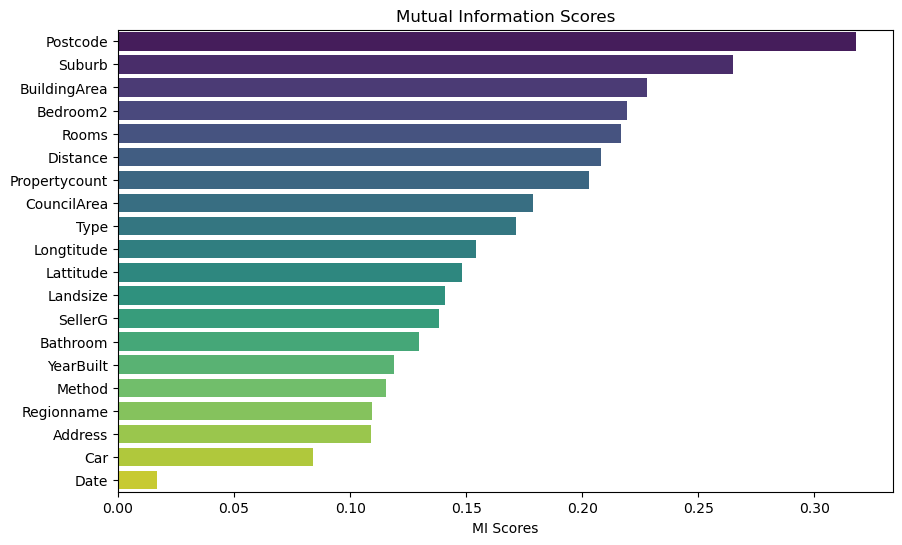

Postcode         0.317908
Suburb           0.264936
BuildingArea     0.227915
Bedroom2         0.219441
Rooms            0.216851
Distance         0.208143
Propertycount    0.202704
CouncilArea      0.178941
Type             0.171515
Longtitude       0.154171
Name: MI Scores, dtype: float64


In [15]:
# MUTUAL INFORMATION SCORES

# Create a new DataFrame without null values
df_m = impute_missing_values(df.copy(deep=True))

# Calculate mutual information scores
X_m = df_m
y_m = X_m.pop(target)

# Calculate mutual information (_r or _c)
m_info_scores = m_info_r(X_m, y_m)

# Plot the mutual information scores
plot_mi_scores(m_info_scores, top_n=20)

# Display the top 10 mutual information scores
print(m_info_scores.head(10))

CATEGORICAL ANALYSIS

In [16]:
# ENCODING RECOMMENDATIONS

def get_encoding_recommendations(df):
    encoding_recommendations = []

    for column in df.select_dtypes(include='object'):
        unique_values = df[column].nunique()

        if unique_values <= 10:
            encoding = 'One-Hot / Label'
        elif unique_values >= 10:
            encoding = 'Target / Frequency'
        else:
            encoding = 'Date Encoding' if df[column].dtype == 'datetime64[ns]' else 'None'

        encoding_recommendations.append({
            'Feature': column,
            'Unique Values': unique_values,
            'Recommended Encoding': encoding
        })

    return pd.DataFrame(encoding_recommendations)

# Example usage with your DataFrame
df_encoding_recommendations = get_encoding_recommendations(df)
df_encoding_recommendations


,Feature,Unique Values,Recommended Encoding
0,Suburb,314,Target / Frequency
1,Address,13378,Target / Frequency
2,Type,3,One-Hot / Label
3,Method,5,One-Hot / Label
4,SellerG,268,Target / Frequency
5,Date,58,Target / Frequency
6,CouncilArea,33,Target / Frequency
7,Regionname,8,One-Hot / Label


In [17]:
explore_categorical_relationships(df, 'Method', target)

NUMERICAL ANALYSIS

In [18]:
# CORRELATION

correlation_matrix = df.corr(numeric_only=True)

# Get the highest correlation values (excluding self-correlations)
highest_corr = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates()
highest_corr = highest_corr[(highest_corr != 1.0) & (highest_corr > 0)]

# Display the highest correlation values
print("\nHighest Correlation Values:")
print(highest_corr[:5])



#seaborn_correlation_matrix(df)


Highest Correlation Values:
Bedroom2      Rooms       0.944190
Rooms         Bathroom    0.592934
Bedroom2      Bathroom    0.584685
BuildingArea  Landsize    0.500485
Price         Rooms       0.496634
dtype: float64


In [19]:
# STATS
summary = df.describe().T.sort_values(by='std', ascending=False).head(10)
summary

,count,mean,std,min,25%,50%,75%,max
Price,13580.0,1.075684e+06,639310.724296,85000.0,650000.0,903000.0,1330000.0,9000000.0
Propertycount,13580.0,7.454417e+03,4378.581772,249.0,4380.0,6555.0,10331.0,21650.0
Landsize,13580.0,5.584161e+02,3990.669241,0.0,177.0,440.0,651.0,433014.0
BuildingArea,7130.0,1.519676e+02,541.014538,0.0,93.0,126.0,174.0,44515.0
Postcode,13580.0,3.105302e+03,90.676964,3000.0,3044.0,3084.0,3148.0,3977.0
YearBuilt,8205.0,1.964684e+03,37.273762,1196.0,1940.0,1970.0,1999.0,2018.0
Distance,13580.0,1.013778e+01,5.868725,0.0,6.1,9.2,13.0,48.1
Bedroom2,13580.0,2.914728e+00,0.965921,0.0,2.0,3.0,3.0,20.0
Car,13518.0,1.610075e+00,0.962634,0.0,1.0,2.0,2.0,10.0
Rooms,13580.0,2.937997e+00,0.955748,1.0,2.0,3.0,3.0,10.0


TARGET ANALYSIS

Skewness: 2.239624
Kurtosis: 9.874339


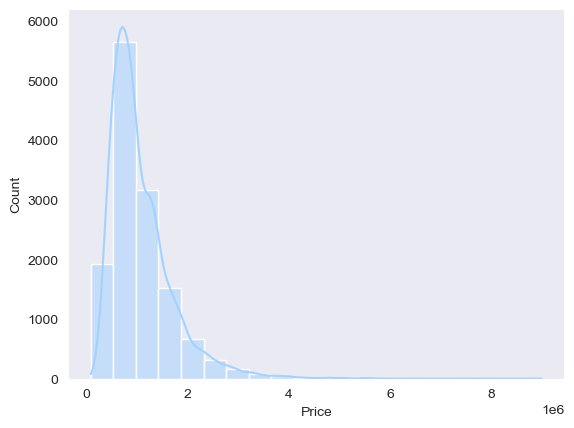

In [20]:
# TARGET DISTRIBUTION

sns.set_style("dark")
sns.set_palette("dark")

# Plot histogram using histplot
sns.histplot(y_m, kde=True, edgecolor='white', linewidth=1, color='#a2d2ff', bins=20)


#skewness and kurtosis
print("Skewness: %f" % y_m.skew())
print("Kurtosis: %f" % y_m.kurt())

In [28]:
# TARGET CORRELATIONS

correlation_matrix = df.corr(numeric_only=True)

# Filter correlations for 'Price' column only
price_correlations = correlation_matrix[target].drop(target).sort_values(ascending=False)

# Display the correlations with 'Price'
print("\nCorrelations with Target:")
print(price_correlations[:3])


Correlations with Target:
Suburb      0.559646
Rooms       0.496634
Bedroom2    0.475951
Name: Price, dtype: float64


In [29]:
# EXPLORE LINEAR REGRESSION

explore_numerical_correlation(df, 'Suburb', target)

Correlation between Suburb and Price: 0.5596457217446087


In [ ]:
# EXPLORE DEPENDENT VARIABLE

explore_dependent_variable(df.Price)

OUTLIER ANALYSIS

In [ ]:
extract_outliers(df)

,Column,Total Outliers
0,Suburb,90
1,Rooms,682
2,Price,624
3,Distance,411
4,Postcode,208
5,Bedroom2,655
6,Bathroom,143
7,Car,0
8,Landsize,368
9,BuildingArea,0


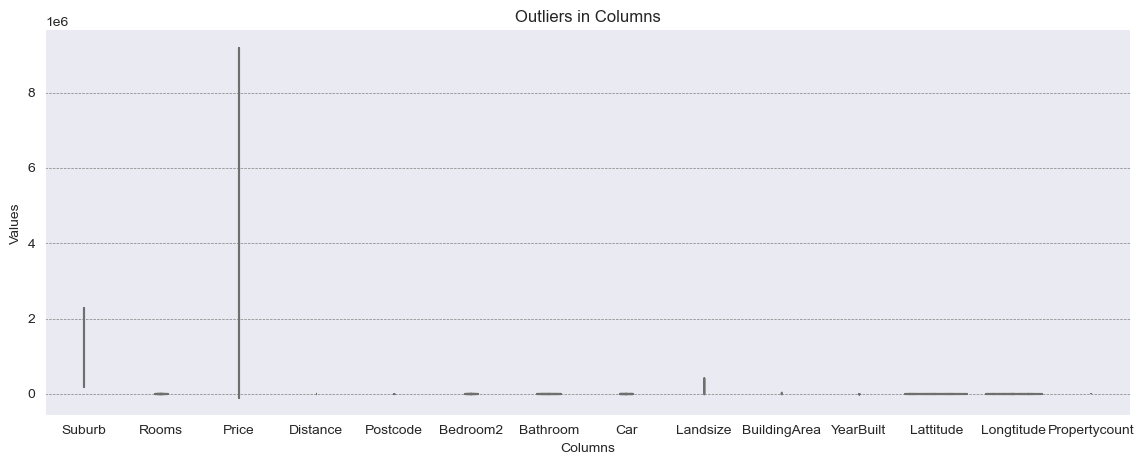

In [30]:
# VISUALIZE & EXTRACT OUTLIERS 


outlier_features = []

# plot_outliers(df[outlier_features], 'violin', (10, 6))

plot_outliers(df, 'violin', (14, 5))





# PREPROCESSING

1. MISSING VALUES

In [44]:
# Create a new DataFrame without null values
df_encoded = impute_missing_values(df.copy(deep=True))

print('Raw Data:',df.isna().sum().max())

print('Encoded Data:', df_encoded.isna().sum().max())




Raw Data: 6450
Encoded Data: 0


2. LABEL ENCODING

In [52]:
# Encoding Recommendations

df_encoding_recommendations

,Feature,Unique Values,Recommended Encoding
0,Suburb,314,Target / Frequency
1,Address,13378,Target / Frequency
2,Type,3,One-Hot / Label
3,Method,5,One-Hot / Label
4,SellerG,268,Target / Frequency
5,Date,58,Target / Frequency
6,CouncilArea,33,Target / Frequency
7,Regionname,8,One-Hot / Label


In [55]:
# Encoding function

import category_encoders as ce

def encode_data(df):
    # Suburb: Target Encoding
    suburb_target_encoding = df.groupby('Suburb')[target].mean()
    df['Suburb'] = df['Suburb'].map(suburb_target_encoding)

    # Address: Hash Encoding
    encoder = ce.HashingEncoder(cols=['Address'])
    df_encoded = encoder.fit_transform(df)

    # Type and Method: One-Hot Encoding
    df_encoded = pd.get_dummies(df_encoded, columns=['Type', 'Method'])

    # SellerG: Frequency Encoding based on Mean Price
    sellerg_frequency_encoding = df.groupby('SellerG')[target].mean()
    df_encoded['SellerG'] = df_encoded['SellerG'].map(sellerg_frequency_encoding)

    # Date: Date Encoding

    df_encoded['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', dayfirst=True)
    df_encoded['Year'] = df_encoded['Date'].dt.year
    df_encoded['Month'] = df_encoded['Date'].dt.month
    df_encoded['Day'] = df_encoded['Date'].dt.day
    df_encoded.drop('Date', axis=1, inplace=True)

    # CouncilArea: Frequency Encoding based on Mean Price
    council_area_frequency_encoding = df.groupby('CouncilArea')[target].mean()
    df_encoded['CouncilArea'] = df_encoded['CouncilArea'].map(council_area_frequency_encoding)

    # Regionname: One-Hot Encoding
    df_encoded = pd.get_dummies(df_encoded, columns=['Regionname'])

    return df_encoded

df_encoded = encode_data(df)



In [56]:
# Print the shape of the data

print("Raw Date:")
print(df.shape)
print()
print("Encoded Data:")
print(df_encoded.shape)

Raw Date:
(13580, 21)

Encoded Data:
(13580, 43)


3. DEALING WITH OUTLIERS

In [47]:
# 3 DEALING WITH OUTLIERS

df_encoded5 = remove_outliers_IQR(df_encoded.copy(deep=True), column=None, k=10) 


print("DataFrame Original:")
print(df.shape)
print()
print("DataFrame without Outliers:")
print(df_encoded5.shape)


DataFrame Original:
(13580, 21)

DataFrame without Outliers:
(13506, 21)


# FEATURES SELECTION

In [50]:
# NEW MUTUAL INFORMATION SCORES

# Create a new DataFrame without null values
df_encoded = impute_missing_values(df.copy(deep=True))

# Calculate mutual information scores
X_encoded = df_encoded.copy(deep=True)
y_encoded = X_encoded.pop(target)

# Calculate mutual information (_r or _c)
m_info_scores = m_info_r(X_encoded, y_encoded)


# Display the top 10 mutual information scores
print(m_info_scores.head(5))


Suburb          0.344442
Postcode        0.317908
BuildingArea    0.227915
Bedroom2        0.219441
Rooms           0.216851
Name: MI Scores, dtype: float64


In [26]:
# TARGET CORRELATIONS

correlation_matrix = df.corr(numeric_only=True)

# Filter correlations for 'Price' column only
price_correlations = correlation_matrix[target].drop(target).sort_values(ascending=False)

# Display the correlations with 'Price'
print("\nCorrelations with 'Price':")
print(price_correlations[:5])



Correlations with 'Price':
Suburb      0.559646
Rooms       0.496634
Bedroom2    0.475951
Bathroom    0.467038
Car         0.238979
Name: Price, dtype: float64


In [27]:
# VISUALIZE SIMPLE REGRESSION

explore_numerical_correlation(df, 'Suburb', target)

Correlation between Suburb and Price: 0.5596457217446087
